In [1]:
import pandas as pd
import numpy as np

In [2]:
TEST_SET='../../datasets/mimic-iii-notes/NOTES_len6K_src5900_cov0.5_w_ESGs_test_split.jsonl'
PREDICTION_SET='../../evaluation/clinical/prediction_output/20240318110341/predictions.jsonl'
METRIC_SET='../../evaluation/clinical/prediction_output/20240318110341/metric_scores.jsonl'

In [3]:
test_set = pd.read_json(TEST_SET, lines=True)
pred_set = pd.read_json(PREDICTION_SET, lines=True)
metric_set = pd.read_json(METRIC_SET, lines=True)

test_set = test_set.rename(columns={'example_id': 'id'})

for df in (test_set, pred_set, metric_set):
    print(df.columns)

Index(['id', 'source', 'target', 'len_source', 'len_target', 'len_total',
       'label_entity_coverage_rate', 'source_orig', 'len_src_tok',
       'len_tgt_tok', 'len_total_tok', 'oracle_salient_ESGs'],
      dtype='object')
Index(['id', 'output'], dtype='object')
Index(['id', 'SGR', 'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4',
       'bs_f1', 'bs_p'],
      dtype='object')


In [4]:
def three_table_inner_join(df1, df2, df3, join_key):
    return pd.merge(
                pd.merge(
                    df1,
                    df2, on=join_key, how='inner'),
                df3, on=join_key, how='inner')

In [5]:
result_set = three_table_inner_join(test_set, pred_set, metric_set, join_key='id')

In [6]:
assert test_set.shape[0] == pred_set.shape[0] == metric_set.shape[0] == result_set.shape[0]

In [7]:
result_set

,id,source,target,len_source,len_target,len_total,label_entity_coverage_rate,source_orig,len_src_tok,len_tgt_tok,...,oracle_salient_ESGs,output,SGR,HR,rouge-1%,rouge-2%,rouge-l%,bleu-4,bs_f1,bs_p
0,19322119378,Sinus rhythm. {{Low limb lead voltage}}. {{Pri...,Patient is a 62 year-old male with metastatic ...,10092,2859,12951,0.579710,Sinus rhythm. Low limb lead voltage. Prior ant...,3585,826,...,"[[Heparinized saline, pericardial drainage, fu...",62 year old male with RCC and pericardial effu...,1.0,0.285714,17.7049,4.4355,11.6638,13.1780,0.284086,0.326228
1,20091116425,Sinus rhythm Possible {{anterior infarct}} - a...,Endocrine: The patient was initially admitted ...,13732,5580,19312,0.670330,Sinus rhythm Possible anterior infarct - age u...,4683,1439,...,"[[Right ventricular systolic function, Sinus b...",The patient was admitted to the hospital for e...,0.0,1.000000,11.2798,2.9954,13.7521,19.5840,0.295257,0.388120
2,12169107757,"Sinus rhythm, without {{diagnostic abnormality...",A P: 71 year old female with multiple medical ...,13436,2363,15799,0.581818,"Sinus rhythm, without diagnostic abnormality. ...",4936,683,...,"[[NPO, BS, ST depression, 2l NC, Left atrial a...",The patient was admitted to the MICU for manag...,1.0,0.666667,19.0114,9.3541,10.6383,10.0210,0.316291,0.394572
3,19738102287,Sinus rhythm. {{Left ventricular hypertrophy}}...,The patient was admitted to the Medical Intens...,7206,3546,10752,0.666667,Sinus rhythm. Left ventricular hypertrophy. Co...,2794,962,...,"[[difficulty, similar ekg changes, Recurrent l...","This is a 75 yo M with a history of CAD, CHF, ...",1.0,0.560000,18.7879,4.4872,11.0983,0.8594,0.331329,0.405261
4,7758102646,2:07 PM CHEST PORTABLE AP Clip # Reason: {{che...,Upper gastrointestinal bleed: Because of his a...,10931,4303,15234,0.625000,2:07 PM CHEST PORTABLE AP Clip # Reason: check...,4191,1160,...,"[[The pulmonary artery systolic pressure, UPPE...",56 year old man with history of colon cancer a...,1.0,0.625000,15.4303,4.0310,7.9162,0.0020,0.307137,0.414593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,77815103081,10:53 AM CAROT CEREB Clip # Reason: {{Stent as...,The patient is a 58 year old man who was elect...,3608,630,4238,0.555556,10:53 AM CAROT CEREB Clip # Reason: Stent assi...,1126,168,...,"[[a 6 French Angio-Seal closure device, A Neur...",{{Stent assisted coiling of aneurysmAnesthesia...,1.0,0.394737,16.2338,2.8829,8.5297,12.6576,0.276482,0.219219
262,30660107310,{{Baseline artifact}}. Sinus rhythm. {{Low lim...,60 yo F longtime smoker with h o COPD and schi...,14559,1129,15688,0.700000,Baseline artifact. Sinus rhythm. Low limb lead...,5542,328,...,"[[O2 SAT, VERY SOB, NPO, mask ventilation, BS,...",The patient was admitted to the medical floor ...,1.0,0.285714,20.1258,6.9264,19.2857,8.2152,0.296593,0.405050
263,31245109216,Patient admitted from OSH in NY. She has PMH o...,The patient was admitted for stent replacement...,15159,1785,16944,0.761905,Patient admitted from OSH in NY. She has PMH o...,5222,466,...,"[[O2 SAT, a persistent tracheoesophageal fistu...",Patient was admitted from OSH in NY. She has P...,1.0,0.401961,22.3859,3.8647,8.8372,23.6548,0.287907,0.265462
264,57507108029,Sinus rhythm. {{Diffuse ST segment elevation}}...,29 yo M w no significant PMH presented with pl...,6223,1388,7611,0.620690,Sinus rhythm. Diffuse ST segment elevation and...,2083,368,...,"[[left ventricular function, a moderate sized ...",The patient was admitted to the hospital for f...,0.0,1.000000,23.6025,3.7594,10.1010,0.4319,0.322081,0.476969


In [8]:
result_set.columns

Index(['id', 'source', 'target', 'len_source', 'len_target', 'len_total',
       'label_entity_coverage_rate', 'source_orig', 'len_src_tok',
       'len_tgt_tok', 'len_total_tok', 'oracle_salient_ESGs', 'output', 'SGR',
       'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p'],
      dtype='object')

In [9]:
metric_keys = ['SGR', 'HR', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p']
for k in metric_keys:
    print(k, np.mean(result_set[k]))

SGR 0.6471078524657895
HR 0.6997857707706767
rouge-1% 19.01717857142857
rouge-2% 5.627095488721805
rouge-l% 11.42838045112782
bleu-4 9.527574060150375
bs_f1 0.30502007386541347
bs_p 0.3842077422180451


In [10]:
# Saving

result_set.to_json('all_merged_for_case_study.jsonl', lines=True, orient='records')
# result_set.to_csv('all_merged_for_case_study.csv', index=False, header=True)

<Axes: xlabel='sample index', ylabel='rate'>

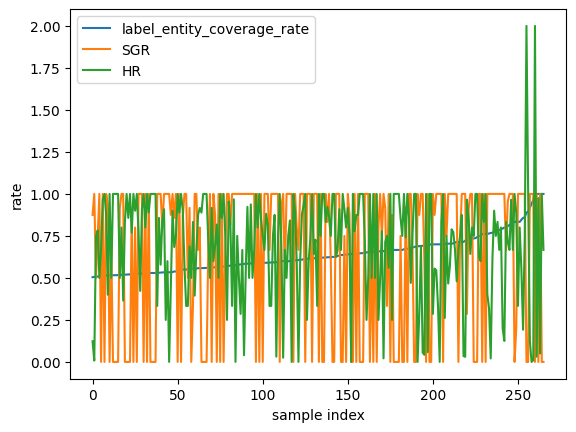

In [11]:
analysis_set = result_set.sort_values(by='label_entity_coverage_rate').reset_index(drop=True)
# analysis_set['normed_SGR'] = analysis_set['SGR']/10
analysis_set.plot(y=['label_entity_coverage_rate', 'SGR', 'HR'], kind='line', ylabel='rate', xlabel='sample index')